# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import random

from IPython.display import HTML

from boruta import BorutaPy

from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import metrics as m
from sklearn import linear_model as lm

/home/cid/.pyenv/versions/3.8.5/envs/rossmann-sales-forecast/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 0.1. Loading Data

In [2]:
df_store_raw = pd.read_csv('../data/store.csv')
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)

# merge
df_raw = pd.merge(df_store_raw, df_sales_raw, how='left', on='Store')

## 0.2. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y ))

def ml_error(model_name, y, yhat):
    mae = m.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(m.mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set_style("whitegrid")
    
    sns.set()

In [4]:
jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


/home/cid/.pyenv/versions/3.8.5/envs/rossmann-sales-forecast/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.0. Data Description

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [23]:
cols_new = ['store', 'store_type', 'assortment', 'competition_distance',
            'competition_open_since_month', 'competition_open_since_year', 'promo2',
            'promo2_since_week', 'promo2_since_year', 'promo_interval',
            'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
            'state_holiday', 'school_holiday']

df1.columns = cols_new

## 1.2. Data Dimensions

In [24]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [25]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.4. Check NA

In [26]:
df1.isna().sum().sort_values(ascending=False)

promo_interval                  508031
promo2_since_week               508031
promo2_since_year               508031
competition_open_since_month    323348
competition_open_since_year     323348
competition_distance              2642
sales                                0
state_holiday                        0
promo                                0
open                                 0
customers                            0
store                                0
date                                 0
day_of_week                          0
store_type                           0
promo2                               0
assortment                           0
school_holiday                       0
dtype: int64

## 1.5. Fillout NA

In [27]:
# promo_interval 
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1: 'Jan', 2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul', 8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov', 12: 'Dec'}
df1['month_promo'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_promo'] in x['promo_interval'].split(',') else 0, axis=1)

# promo2_since_week,  promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# competition_open_since_year, competition_open_since_month
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_distance
df1['competition_distance'].fillna(200000.0, inplace=True)

## 1.6. Change Data Types

In [28]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [29]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [30]:
# Central Tendency: mean, median
c1 = pd.DataFrame(num_attributes.apply(np.mean))
c2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion: min, max, range, std, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min))
d2 = pd.DataFrame(num_attributes.apply(max))
d3 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) - np.min(x)))
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.std()))
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

# concat
m = pd.concat([d1,d2,d3,c1,c2,d4,d5,d6], axis=1).reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
2,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
3,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07
4,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
5,promo2_since_week,1.00,52.00,51.00,23.62,22.00,14.31,0.18,-1.18
6,promo2_since_year,2009.00,2015.00,6.00,2012.79,2013.00,1.66,-0.78,-0.21
7,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
8,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
9,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09


### 1.7.2. Categorical Attributes

In [31]:
cat_attributes.describe(include=['object'])

,store_type,assortment,promo_interval,state_holiday,month_promo
count,1017209,1017209,1017209,1017209,1017209
unique,4,3,4,4,12
top,a,a,0,0,Mar
freq,551627,537445,508031,986159,103695


In [32]:
# pickle.dump(df1, open('../src/data/df1.pkl', 'wb'))

# 2.0. Feature Engineering

In [33]:
df2 = pickle.load(open('../src/data/df1.pkl', 'rb'))

## 2.* Feature Engineering

In [34]:
# date: year, month, day, week_of_year, year_week
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_open_since_year  - competition_open_since_month
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo2_since_year, promo2_since_week
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w'))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# public_holiday
state_holiday_dict = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_dict)

# assortment
assortment_dict = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_dict)

In [35]:
# pickle.dump(df2, open('../src/data/df2.pkl', 'wb'))

# 3.0. Data Filtering

In [51]:
df3 = pickle.load(open('../src/data/df2.pkl', 'rb'))

## 3.1. Filter Rows

In [52]:
df3 = df3[(df3['open'] != 0)&(df3['sales'] > 0)]

## 3.2. Filter Columns

In [53]:
drop_cols = ['open', 'month_promo', 'customers', 'promo_interval']
df3 = df3.drop(drop_cols, axis=1)

In [54]:
# pickle.dump(df3, open('../src/data/df3.pkl', 'wb'))

# 4.0. Exploratory Data Analysis

In [7]:
df4 = pickle.load(open('../src/data/df3.pkl', 'rb'))

## 4.1. Analysis Univariate

### 4.1.1. Response

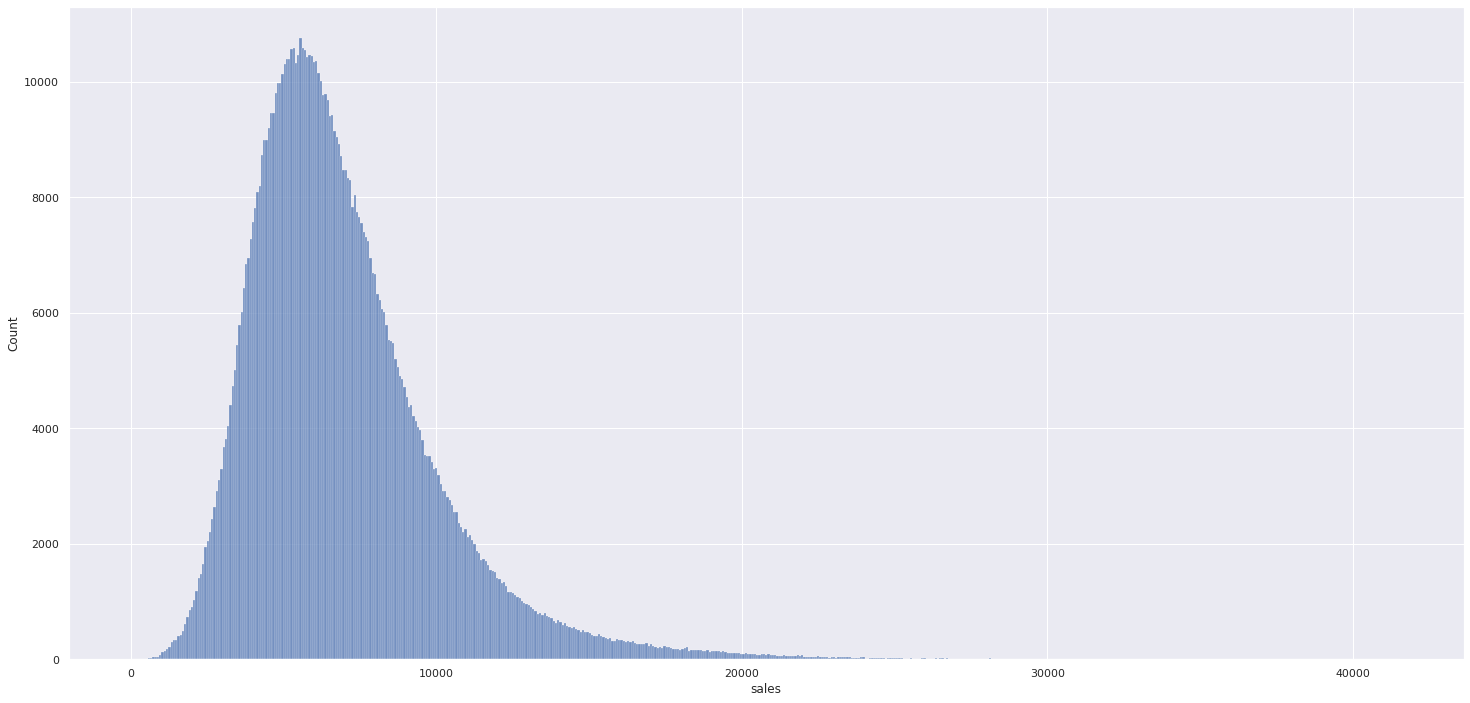

In [11]:
sns.histplot(df4['sales']);

### 4.1.2. Numerical

/home/cid/.pyenv/versions/3.8.5/envs/rossmann-sales-forecast/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


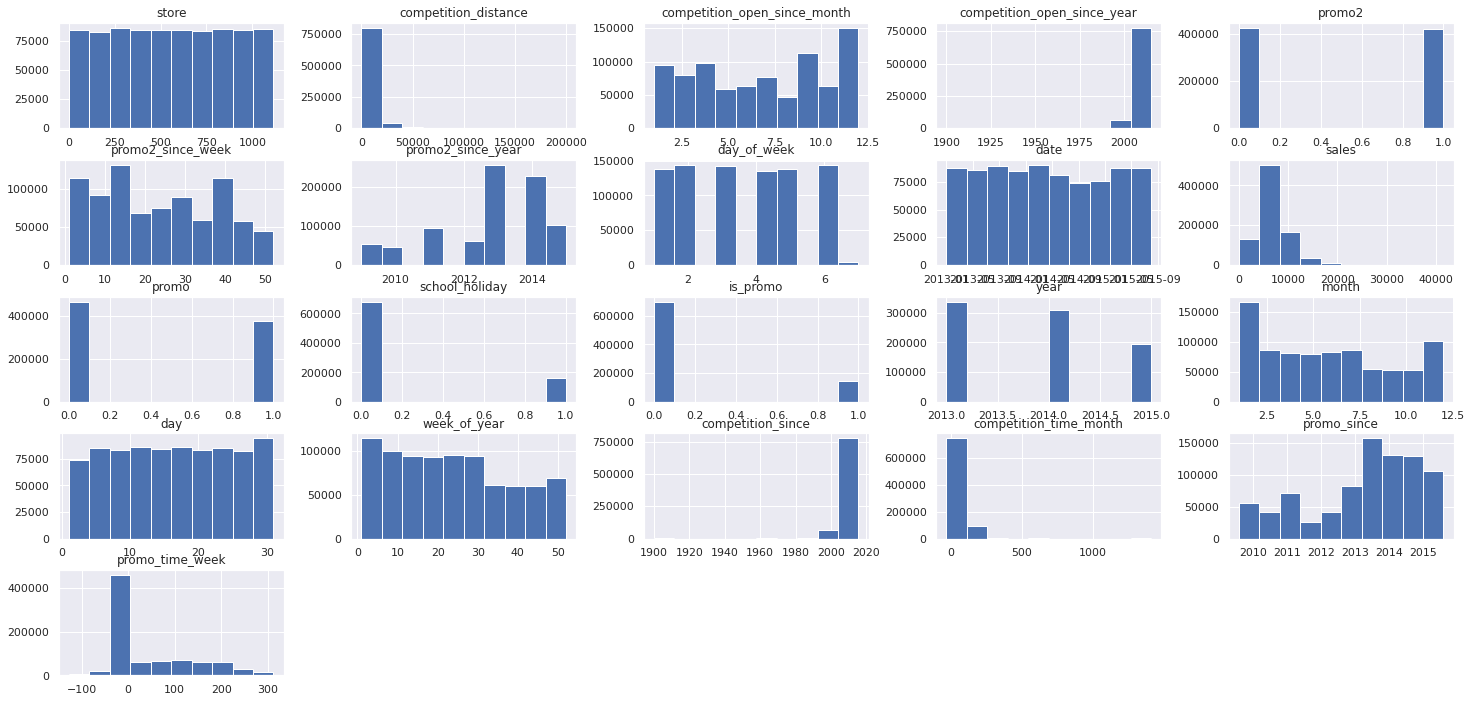

In [8]:
df4.hist();

### 4.1.3. Categorical

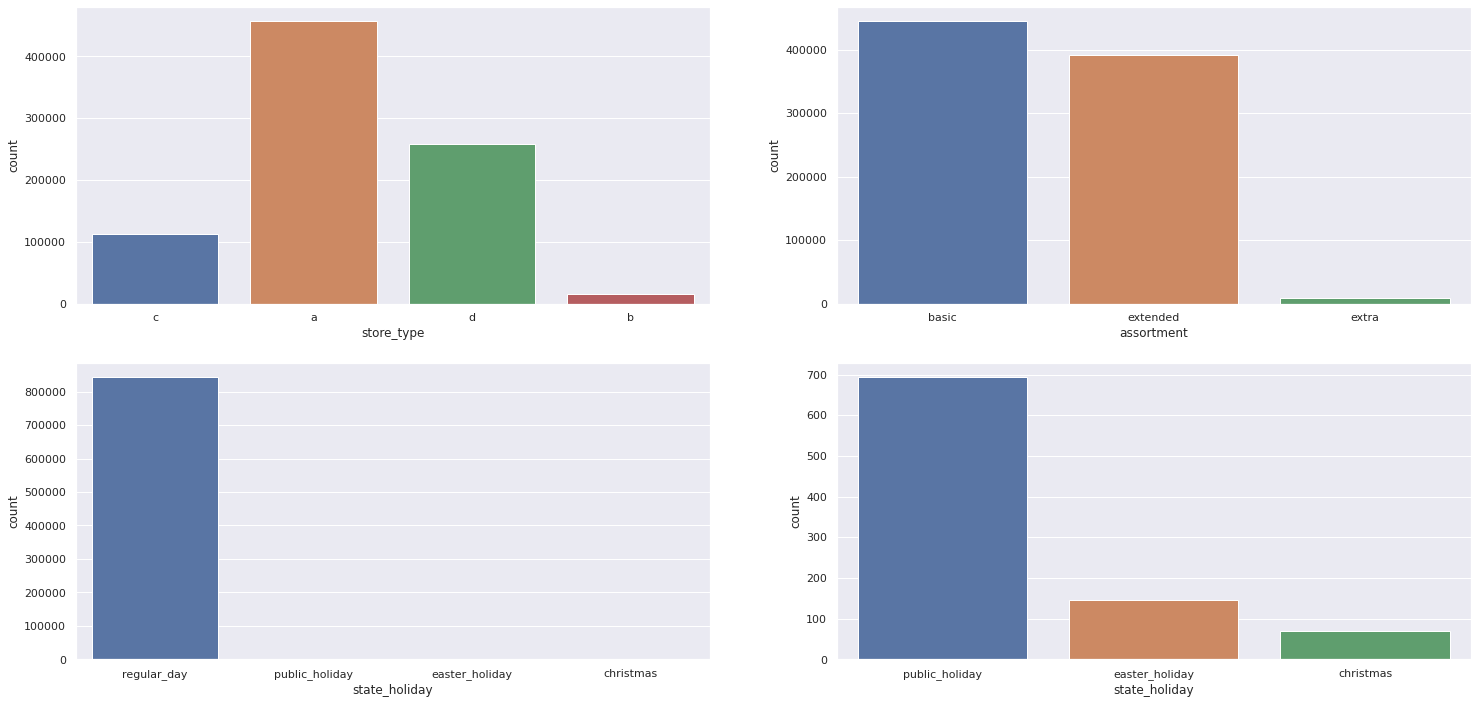

In [21]:
plt.subplot(2,2,1)
sns.countplot(data=df4, x='store_type')

plt.subplot(2,2,2)
sns.countplot(data=df4, x='assortment')

plt.subplot(2,2,3)
sns.countplot(data=df4, x='state_holiday')


plt.subplot(2,2,4)
sns.countplot(data=df4[df4['state_holiday'] != 'regular_day'], x='state_holiday')

plt.show();

## 4.2. Analysis Bivariate

## 4.3. Analysis Multivariate

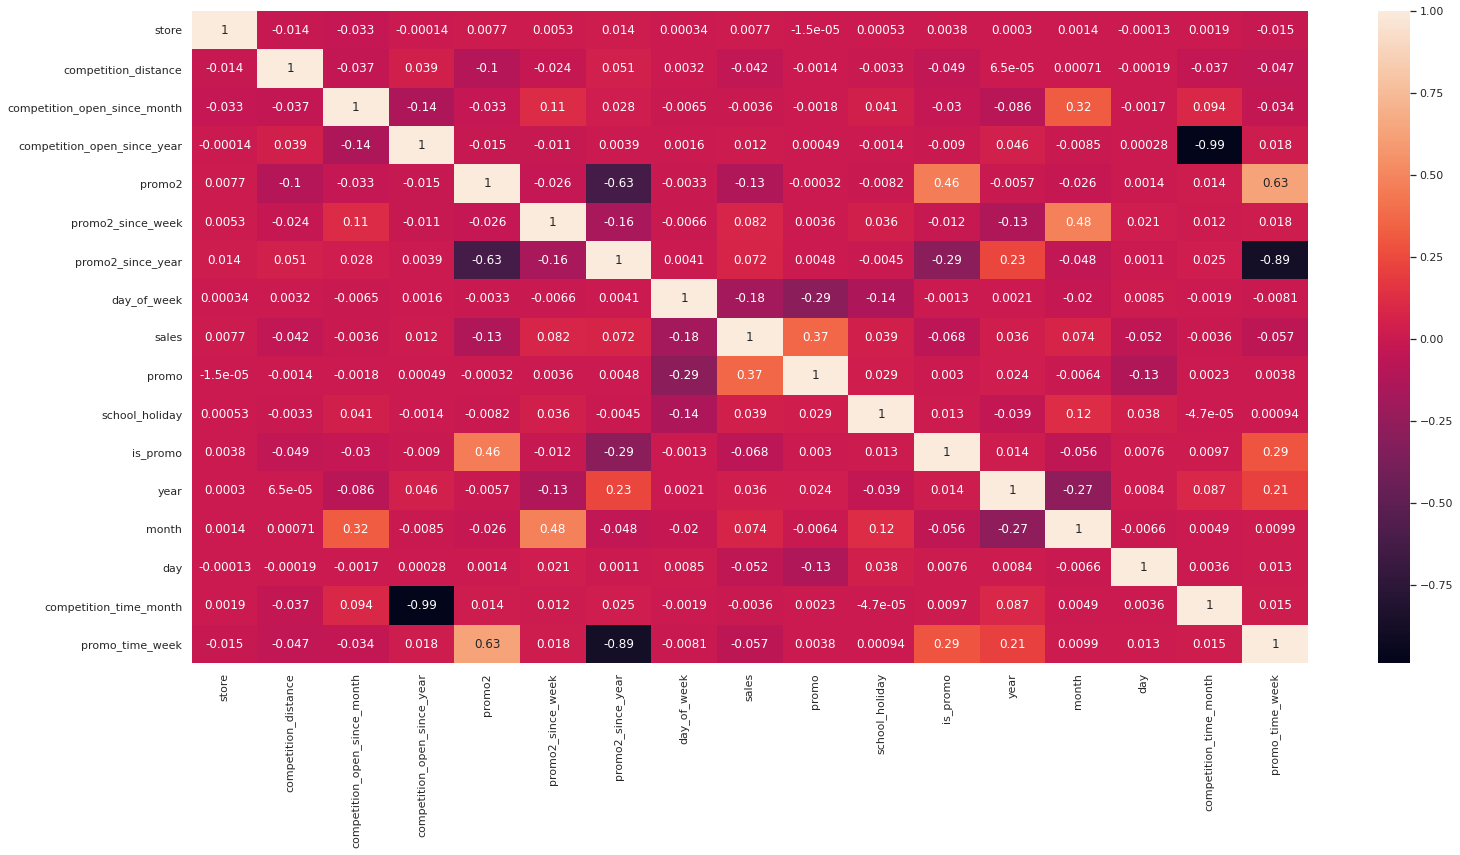

In [23]:
correlation = df4.select_dtypes(include=['int64', 'float64']).corr(method='pearson')

sns.heatmap(correlation, annot=True);

# 5.0. Data Preparation



In [67]:
df5 = pickle.load(open('../src/data/df3.pkl', 'rb'))

## 5.1. Standardization

## 5.2. Scaling

In [68]:
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [69]:
# label encoder
le = pp.LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# OneHot Encoder
df5 = pd.get_dummies(df5, prefix='state_holiday', columns=['state_holiday'])

# Ordinal Encoder
df5['assortment'] = df5['assortment'].map({'basic': 0, 'extended': 2, 'extra': 1})

### 5.3.2. Reponse Transformation

In [70]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature 

In [71]:
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))

df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/31)))
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/31)))

df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))

df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))

In [74]:
# pickle.dump(df5, open('../src/data/df5.pkl', 'wb'))

# 6.0. Selection Feature

In [8]:
df6 = pickle.load(open('../src/data/df5.pkl', 'rb'))

## 6.1. Splitting data into training and test datasets

In [9]:
drop_cols = ['day_of_week', 'month', 'day', 'week_of_year', 'year_week', 'competition_since', 'promo_since']
df6 = df6.drop(drop_cols, axis=1)

In [10]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [11]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2. Boruta as a Feature Selection

In [12]:
# X_train_fs = X_train.drop(['sales', 'date'], axis=1).values
# y_train_fs = y_train.values.ravel()

# rf = en.RandomForestRegressor(n_jobs=1)

# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_fs, y_train_fs)

In [13]:
# cols_selected_boruta = X_train.drop(['date', 'sales'], axis=1).loc[:, boruta.support_].columns.tolist()
# cols_not_selected_boruta = np.setdiff1d(X_train.drop(['date', 'sales'], axis=1).columns.tolist(), cols_selected_boruta).tolist()

## 6.3. Manual Selection 

In [14]:
cols_selected_boruta = ['store','store_type','assortment',
                        'competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week',
                        'promo2_since_year','promo',
                        'competition_time_month','promo_time_week',
                        'month_cos','month_sin','day_cos','day_sin',
                        'week_of_year_cos','week_of_year_sin',
                        'day_of_week_cos','day_of_week_sin']

cols_selected_boruta_full = cols_selected_boruta.copy()
feat_add = ['sales', 'date']
cols_selected_boruta_full.extend(feat_add)

# 7.0. Machine Learning Modelling

In [15]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [13]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux2 = pd.merge(aux1, aux2, on='store', how='left')
yhat_baseline = aux2['predictions']

# perfomance
result_baseline = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
result_baseline

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.41,1835.14


## 7.2. Linear Regression

In [16]:
# model defition and training
lr_model = lm.LinearRegression().fit(x_train, y_train)

# predictions
yhat_lr = lr_model.predict(x_test)

# perfomance
result_lr = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
result_lr

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.65,0.29,2671.33


### 7.2.1.  Linear Regression - Cross Validation

In [21]:
result_lr_cv = cross_validation(x_training, 5, 'Linear Regression', lr_model)
result_lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22


## 7.3. Linear Regression - Lasso

In [24]:
# model definition and training
lrr_model = lm.Lasso(alpha=1.0, normalize=False, random_state=43).fit(x_train, y_train)

# predictions
yhat_lrr = lrr_model.predict(x_test)

# perfomance
result_lrr = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
result_lrr

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2198.58,0.34,3110.51


### 7.3.1 Linear Regression - Lasso - Cross Validation

In [25]:
result_lrr_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr_model)
result_lrr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


## 7.4. Random Forest Regressor

In [14]:
# model definition and training
rf_model = en.RandomForestRegressor(n_estimators=100, 
                                    max_depth=None, 
                                    max_features='auto', 
                                    min_samples_split=2, 
                                    random_state=42).fit(x_train, y_train)

# predictions
yhat_rf = rf_model.predict(x_test)

# perfomance
result_rf = ml_error('Random Forest Regressor', np.expm1(y_test) ,np.expm1(yhat_rf))
result_rf

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.98,0.10,1014.89


### 7.4.1 Random Forest Regressor - Cross Validation



In [28]:
result_rf_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf_model)
result_rf_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,862.94 +/- 252.82,0.12 +/- 0.03,1302.55 +/- 390.2


## 7.5.XGBoost Regressor

In [29]:
# model definition and training
xgb_model = xgb.XGBRFRegressor(objective='reg:squarederror', 
                               n_estimators=100, 
                               eta=0.3, max_depth=6, 
                               subsample=1, 
                               colsample_bytree=1, 
                               random_state=42 ).fit(x_train, y_train)

# predictions
yhat_xgb = xgb_model.predict(x_test)

# perfomance
result_xgb = ml_error('XGBoost Regressor', np.expm1(y_test) ,np.expm1(yhat_xgb))
result_xgb

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1810.11,0.27,2608.08


### 7.5.1 XGBoost Regressor - Cross Validation

In [30]:
result_xgb_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb_model)
result_xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2008.59 +/- 295.77,0.28 +/- 0.01,2869.88 +/- 435.55


## 7.6. Machine Learning Model's Performance

### 7.6.1. Single Perfomance

In [34]:
result = pd.concat([result_baseline, result_lr, result_lrr, result_rf, result_xgb]).sort_values('RMSE', ascending=True)
result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.75,0.10,1014.47
0,Average Model,1354.80,0.41,1835.14
0,XGBoost Regressor,1810.11,0.27,2608.08
0,Linear Regression,1867.65,0.29,2671.33
0,Linear Regression - Lasso,2198.58,0.34,3110.51


### 7.6.2. Cross Validation 

In [35]:
result_cv = pd.concat([result_lr_cv, result_lrr_cv, result_rf_cv, result_xgb_cv])
result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22
0,Linear Regression - Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55
0,Random Forest Regressor,862.94 +/- 252.82,0.12 +/- 0.03,1302.55 +/- 390.2
0,XGBoost Regressor,2008.59 +/- 295.77,0.28 +/- 0.01,2869.88 +/- 435.55


# 8.0. Hyperameter Fine Tunning

## 8.1. Random Search

In [16]:
# param = {'n_estimators':[100, 1000],
#          'max_depth':[None,10, 10] ,
#          'max_features':['auto'], 
#          'min_samples_split':[2, 3]}

# MAX_EVAL = 5

In [18]:
# result_final = pd.DataFrame()

# for i in range(MAX_EVAL):
#     hp = {key: random.sample( value, 1)[0] for key, value in param.items()}
#     print(hp)
    
#     rf_model = en.RandomForestRegressor(n_estimators=hp["n_estimators"], 
#                                         max_depth=hp["max_depth"], 
#                                         max_features=hp["max_features"], 
#                                         min_samples_split=hp["min_samples_split"], 
#                                         random_state=42)
    
#     result = cross_validation(x_training, 5, 'Random Forest Regessor', rf_model)
#     result_final = pd.concat([result, result_final])

# result_final

{'n_estimators': 1000, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2}
{'n_estimators': 100, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2}
{'n_estimators': 100, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 3}
{'n_estimators': 1000, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 3}
{'n_estimators': 100, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regessor,1756.2 +/- 254.7,0.24 +/- 0.01,2483.34 +/- 363.75
0,Random Forest Regessor,1755.76 +/- 254.53,0.24 +/- 0.01,2482.76 +/- 363.08
0,Random Forest Regessor,864.88 +/- 256.44,0.12 +/- 0.03,1304.92 +/- 396.89
0,Random Forest Regessor,1756.37 +/- 254.72,0.24 +/- 0.01,2483.73 +/- 363.92
0,Random Forest Regessor,1755.9 +/- 254.7,0.24 +/- 0.01,2482.97 +/- 363.32


## 8.2. Final Model

In [21]:
hp_final = {'n_estimators': 100, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 3}

In [24]:
# model definition and training
rf_model = en.RandomForestRegressor(n_estimators=hp_final["n_estimators"], 
                                    max_depth=hp_final["max_depth"], 
                                    max_features=hp_final["max_features"], 
                                    min_samples_split=hp_final["min_samples_split"], 
                                    random_state=42).fit(x_train, y_train)

# predictions
yhat_rf = rf_model.predict(x_test)

# perfomance
result_rf = ml_error('Random Forest Regressor', np.expm1(y_test) ,np.expm1(yhat_rf))
result_rf

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.15,0.10,1017.61


# 9.0. Convert Machine Learning Model into Business Value

# 10. API